In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#from sklearnex import patch_sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from tqdm import tqdm, tnrange
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
#patch_sklearn()
warnings.filterwarnings('ignore')

In [ ]:
device = torch.device('cuda')
torch.cuda.set_device(0)
print('Using device:', device)
print()

In [3]:
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

NVIDIA GeForce RTX 3060
Memory Usage:
Allocated: 0.0 GB
Cached: 0.0 GB


# 1. Estude o notebook “A Visual Notebook to Using BERT for the First Time.ipynb”, anexo a essa lista.

## a) Resolva o mesmo problema de classificação da segunda questão da segunda lista, usando uma combinação de DistilBERT com os três classificadores usados na segunda lista.

In [2]:
df = pd.read_csv("clean_dataset_no_stemming.csv")
display(df['clean_text'].head(5))
print(df.shape)

0    uk manufacturing sector continue face serious ...
1    climate change fight aids leading list concern...
2    shares europe leading reinsurers travel firms ...
3    shares india largest power producer national t...
4    luxury goods group lvmh sold loss making chris...
Name: clean_text, dtype: object

(2225, 5)


### Binarizando

In [5]:
new_target = {'sport': 1, 'business': 0, 'politics': 0, 'tech': 0, 'entertainment': 0}
df['binary_target'] = df['target'].map(new_target)
print(df['binary_target'].value_counts())

0    1714
1     511
Name: binary_target, dtype: int64


### Carregando modelo BERT

In [6]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

## Want BERT instead of distilBERT? Uncomment the following line:
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)
model = model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Tokenizando

In [7]:
tokenized = df['clean_text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True, truncation= True)))

### Padding

In [8]:
max_len = 0
counter = 0
max_possible_len = 512
for index,i in enumerate(tokenized.values):
    # cropping input to length 512
    if len(i) > max_possible_len:
        tokenized.values[index] = i[:max_possible_len-1]
        # get the length
    if len(i) > max_len:
        max_len = len(tokenized.values[index])
print(max_len)
padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

512


In [9]:
np.array(padded).shape

(2225, 512)

### Masking

In [10]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(2225, 512)

### Deep Learning

In [11]:
batch_size = 220

features_x = []
attention_x = []

input_ids = torch.tensor(padded)#.to(device) 
attention_mask = torch.tensor(attention_mask)#.to(device)

for i in tqdm(range(int(input_ids.shape[0]/batch_size)+1)):
    input_data = input_ids[i*batch_size:(i+1)*batch_size].to(device) 
    attention_data = attention_mask[i*batch_size:(i+1)*batch_size].to(device)
    with torch.no_grad():
        last_hidden_states = model(input_data, attention_mask=attention_data)
    x = last_hidden_states[0][:,0,:].cpu().numpy()
    features_x.extend(x)


100%|██████████| 11/11 [00:17<00:00,  1.61s/it]


In [12]:
del last_hidden_states

In [13]:
labels = df['binary_target'].values

In [14]:
train_features, test_features, train_labels, test_labels = train_test_split(features_x, labels, test_size = 0.2, stratify= labels)

Accuracy: 0.99
Auc: 1.0
Detail:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       343
           1       0.97      1.00      0.99       102

    accuracy                           0.99       445
   macro avg       0.99      1.00      0.99       445
weighted avg       0.99      0.99      0.99       445



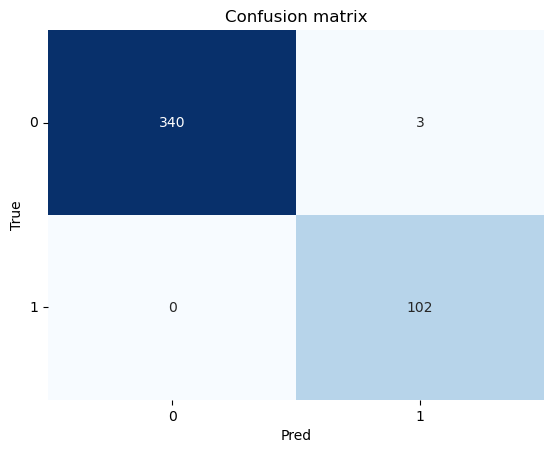

In [15]:
def bert_logistic_regression(X_train,X_test,y_train,y_test):
    clf = LogisticRegression(n_jobs = -1)
    clf.fit(X_train,y_train)

    predicted = clf.predict(X_test)
    predicted_prob = clf.predict_proba(X_test)
    y_test1 = y_test.reshape(-1,1).flatten()

    classes = np.unique(y_test1)
    y_test_array = pd.get_dummies(y_test1, drop_first=False).values
        
    ## Accuracy, Precision, Recall
    accuracy = metrics.accuracy_score(y_test1, predicted)
    auc = metrics.roc_auc_score(y_test_array, predicted_prob)
    print("Accuracy:",  round(accuracy,2))
    print("Auc:", round(auc,2))
    print("Detail:")
    print(metrics.classification_report(y_test1, predicted))
        
    ## Plot confusion matrix
    cm = metrics.confusion_matrix(y_test1, predicted)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
                cbar=False)
    ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
        yticklabels=classes, title="Confusion matrix")
    plt.yticks(rotation=0)

    return metrics.classification_report(y_test1, predicted,output_dict=True)

metrics_bert_lr = bert_logistic_regression(train_features,test_features,train_labels,test_labels)

Accuracy: 0.98
Auc: 0.99
Detail:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       343
           1       0.96      0.94      0.95       102

    accuracy                           0.98       445
   macro avg       0.97      0.96      0.97       445
weighted avg       0.98      0.98      0.98       445



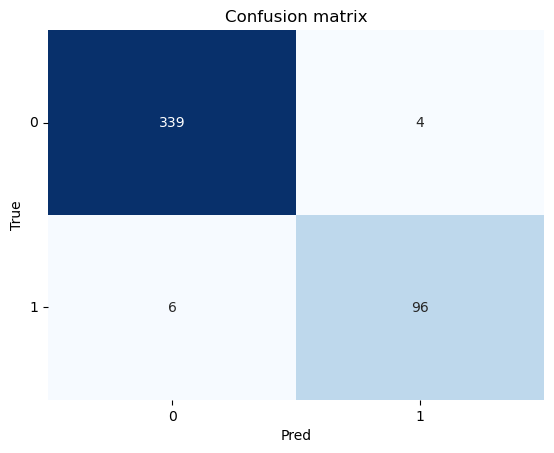

In [16]:
def bert_gaussian_nb(X_train,X_test,y_train,y_test):
    clf = GaussianNB()
    clf.fit(X_train,y_train)

    predicted = clf.predict(X_test)
    predicted_prob = clf.predict_proba(X_test)
    y_test1 = y_test.reshape(-1,1).flatten()

    classes = np.unique(y_test1)
    y_test_array = pd.get_dummies(y_test1, drop_first=False).values
        
    ## Accuracy, Precision, Recall
    accuracy = metrics.accuracy_score(y_test1, predicted)
    auc = metrics.roc_auc_score(y_test_array, predicted_prob)
    print("Accuracy:",  round(accuracy,2))
    print("Auc:", round(auc,2))
    print("Detail:")
    print(metrics.classification_report(y_test1, predicted))
        
    ## Plot confusion matrix
    cm = metrics.confusion_matrix(y_test1, predicted)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
                cbar=False)
    ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
        yticklabels=classes, title="Confusion matrix")
    plt.yticks(rotation=0)

    return metrics.classification_report(y_test1, predicted,output_dict=True)

metrics_bert_gaussian_nb = bert_gaussian_nb(train_features,test_features,train_labels,test_labels)

Accuracy: 0.97
Auc: 0.98
Detail:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       343
           1       0.89      1.00      0.94       102

    accuracy                           0.97       445
   macro avg       0.94      0.98      0.96       445
weighted avg       0.97      0.97      0.97       445



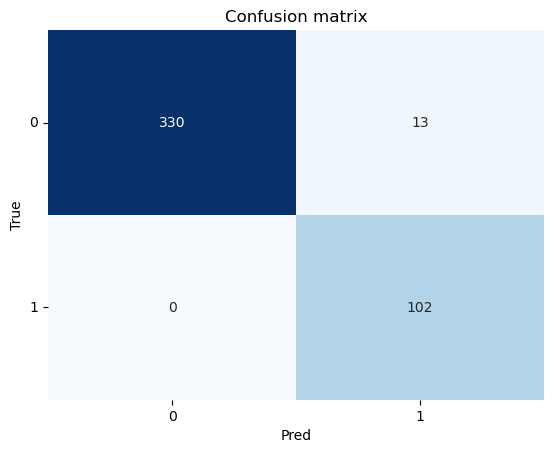

In [17]:
def bert_sgd(X_train,X_test,y_train,y_test):
    clf = SGDClassifier(n_jobs = -1, loss = 'modified_huber')
    clf.fit(X_train,y_train)

    predicted = clf.predict(X_test)
    predicted_prob = clf.predict_proba(X_test)
    y_test1 = y_test.reshape(-1,1).flatten()

    classes = np.unique(y_test1)
    y_test_array = pd.get_dummies(y_test1, drop_first=False).values
        
    ## Accuracy, Precision, Recall
    accuracy = metrics.accuracy_score(y_test1, predicted)
    auc = metrics.roc_auc_score(y_test_array, predicted_prob)
    print("Accuracy:",  round(accuracy,2))
    print("Auc:", round(auc,2))
    print("Detail:")
    print(metrics.classification_report(y_test1, predicted))
        
    ## Plot confusion matrix
    cm = metrics.confusion_matrix(y_test1, predicted)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
                cbar=False)
    ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
        yticklabels=classes, title="Confusion matrix")
    plt.yticks(rotation=0)

    return metrics.classification_report(y_test1, predicted,output_dict=True)

metrics_bert_sgd = bert_sgd(train_features,test_features,train_labels,test_labels)

In [18]:
torch.cuda.empty_cache()

## b) Compare todos os resultados.

In [20]:
metric_list = [metrics_bert_lr,metrics_bert_gaussian_nb,metrics_bert_sgd]
metrics = ['DistilBERT_LogisticRegression','DistilBERT_NaiveBayes','DistilBERT_SGD']

print('F1 Score de todas as variações com DistilBERT:')

for i, metric in enumerate(metric_list):
    print( metrics[i] + ' -> ' + str(metric['macro avg']['f1-score']))

print('''\nF1 Score de todas as 6 variações da lista 2:
CountVectorizer_LogisticRegression -> 0.9978756896853286
TF_IDF_LogisticRegression -> 0.9508113318695443
CountVectorizer_NaiveBayes -> 0.9652806652806654
TF_IDF_NaiveBayes -> 0.9647656095470429
CountVectorizer_SGD -> 0.991483068135455
TF_IDF_SGD -> 0.9936270690559857
\nF1 Score de todos os modelos com Doc2Vec:
Doc2Vec_LogisticRegression -> 0.9954576981137208
Doc2Vec_NaiveBayes -> 0.7139673243811819
Doc2Vec_SGD -> 0.9885528232370834
\nF1 Score de todos os modelos com Deep Learning:
Conv1D -> 0.9821192622184753
LSTM -> 0.9948031306266785''')

F1 Score de todas as variações com DistilBERT:
DistilBERT_LogisticRegression -> 0.9905574299233983
DistilBERT_NaiveBayes -> 0.9679800828920101
DistilBERT_SGD -> 0.960387836292548

F1 Score de todas as 6 variações da lista 2:
CountVectorizer_LogisticRegression -> 0.9978756896853286
TF_IDF_LogisticRegression -> 0.9508113318695443
CountVectorizer_NaiveBayes -> 0.9652806652806654
TF_IDF_NaiveBayes -> 0.9647656095470429
CountVectorizer_SGD -> 0.991483068135455
TF_IDF_SGD -> 0.9936270690559857

F1 Score de todos os modelos com Doc2Vec:
Doc2Vec_LogisticRegression -> 0.9954576981137208
Doc2Vec_NaiveBayes -> 0.7139673243811819
Doc2Vec_SGD -> 0.9885528232370834

F1 Score de todos os modelos com Deep Learning:
Conv1D -> 0.9821192622184753
LSTM -> 0.9948031306266785


# 2. Estude e pesquise sobre o BERTopic, uma adaptação do BERT para modelagem de tópicos. O código fonte está disponível em https://github.com/MaartenGr/BERTopic.

## a) Extraia os tópicos de sua base, exibindo as informações dos tópicos (palavras mais relevantes).

In [1]:
from bertopic import BERTopic
import pandas as pd

df = pd.read_csv("../clean_dataset_no_stemming.csv")
docs = df['clean_text'].to_list()

c:\Users\Alvaro\anaconda3\envs\pln\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = BERTopic(language="english")
topics, probs = model.fit_transform(docs)

In [3]:
model.get_topic_info()

,Topic,Count,Name
0,-1,350,-1_said_mr_would_government
1,0,261,0_mobile_people_technology_games
2,1,175,1_chelsea_club_arsenal_liverpool
3,2,160,2_film_best_actor_films
4,3,150,3_england_wales_ireland_rugby
5,4,119,4_music_band_album_song
6,5,86,5_roddick_open_seed_australian
7,6,71,6_race_olympic_indoor_champion
8,7,59,7_show_tv_series_channel
9,8,57,8_police_said_government_rights


-1_said_would_mr_people é outlier e deve ser ignorado

In [5]:
model.get_topic_freq().head(5)

,Topic,Count
0,-1,425
1,0,337
2,1,159
3,2,117
4,3,71


In [6]:
model.get_topic(0)[:10]

[('england', 0.01932160890943407),
 ('club', 0.016687252421740167),
 ('game', 0.01597304308682058),
 ('side', 0.014178340015847179),
 ('wales', 0.012886270175525695),
 ('players', 0.012800971694446559),
 ('ireland', 0.012516599601880491),
 ('rugby', 0.012322156294364475),
 ('half', 0.01206383123998931),
 ('chelsea', 0.011792507199783565)]

In [7]:
model.topics_[:10]

[11, 29, 26, 37, 33, 9, -1, 9, 9, 9]

In [9]:
print(len(topics), len(probs)) # pega o tópico de cada documento

2225 2225


In [10]:
my_info = model.get_topic_info()
print(my_info)

    Topic  Count                                       Name
0      -1    425                    -1_said_would_mr_people
1       0    337                   0_england_club_game_side
2       1    159                    1_film_best_actor_films
3       2    117                    2_music_band_album_song
4       3     71             3_race_olympic_indoor_champion
5       4     54           4_police_rights_government_human
6       5     51            5_ebbers_fraud_company_worldcom
7       6     50  6_technology_gadgets_digital_technologies
8       7     50                  7_roddick_seed_nadal_open
9       8     47                    8_blair_labour_mr_brown
10      9     44                     9_spam_mail_virus_site
11     10     43          10_mobile_phone_phones_technology
12     11     35              11_airline_airlines_air_delta
13     12     32               12_rates_growth_economy_bank
14     13     32                  13_games_game_xbox_gaming
15     14     30            14_yukos_rus

In [23]:
# ignora a primeira linha pois é outliers
for index, row in my_info[1:].iterrows():
    print(f"{row['Topic']}\t->\t {row['Name']}\n\t->\t{[(i[0], '{:.3f}'.format(i[1])) for i in model.get_topic(row['Topic'])[:6]]}")

0	->	 0_england_club_game_side
	->	[('england', '0.019'), ('club', '0.017'), ('game', '0.016'), ('side', '0.014'), ('wales', '0.013'), ('players', '0.013')]
1	->	 1_film_best_actor_films
	->	[('film', '0.054'), ('best', '0.030'), ('actor', '0.021'), ('films', '0.020'), ('director', '0.019'), ('awards', '0.018')]
2	->	 2_music_band_album_song
	->	[('music', '0.031'), ('band', '0.030'), ('album', '0.029'), ('song', '0.023'), ('best', '0.019'), ('rock', '0.017')]
3	->	 3_race_olympic_indoor_champion
	->	[('race', '0.035'), ('olympic', '0.035'), ('indoor', '0.030'), ('champion', '0.027'), ('championships', '0.026'), ('holmes', '0.024')]
4	->	 4_police_rights_government_human
	->	[('police', '0.026'), ('rights', '0.020'), ('government', '0.019'), ('human', '0.019'), ('said', '0.017'), ('law', '0.017')]
5	->	 5_ebbers_fraud_company_worldcom
	->	[('ebbers', '0.032'), ('fraud', '0.031'), ('company', '0.026'), ('worldcom', '0.025'), ('mr', '0.025'), ('sec', '0.021')]
6	->	 6_technology_gadgets_

## b) Exiba visualizações com gráficos de barra e usando visualize topics().

In [3]:
model.visualize_topics()

In [5]:
'''
Parameters                                                                      Default
topics: List[int]   |       A selection of topics to visualize.             |   None


top_n_topics: int   |       Only select the top n most frequent topics.     |   8	


n_words: int        |       Number of words to show in a topic              |   5
'''

model.visualize_barchart()

Plotando como imagens fixas e não-interativas

In [4]:
import plotly.io as pio
pio.renderers.default = "svg"

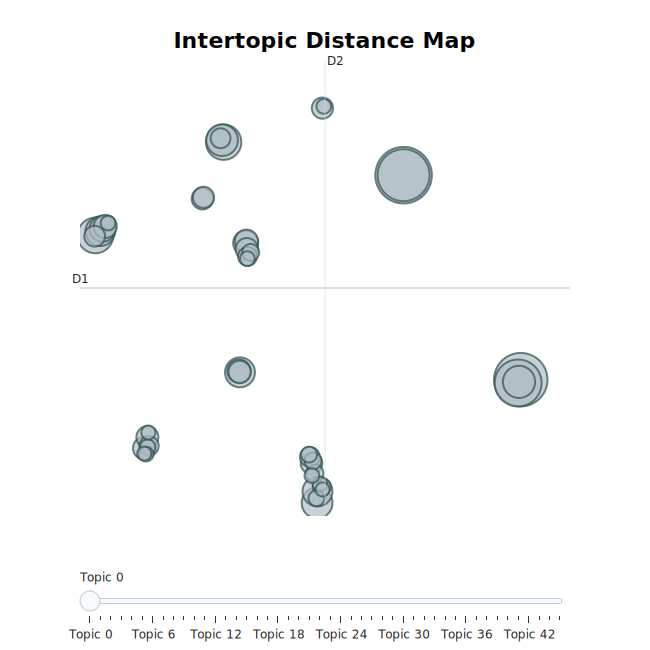

In [5]:
model.visualize_topics()

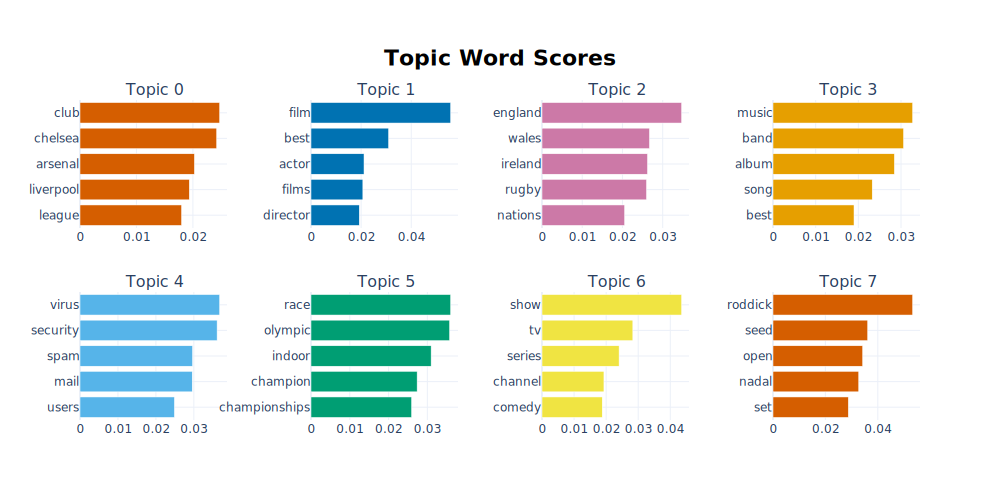

In [6]:
model.visualize_barchart()

# 3. Para apresentação final do curso, organize os principais resultados obtidos nas quatro listas:

### a) Lista 1: questões 6, 7 e 8

Arquivo Lista4/lista1.ipynb

### b) Lista 2: questões 2, 3, 4 e 5

Arquivo Lista4/lista2.ipynb

### c) Lista 3: questões 2 e 4

Arquivo Lista4/lista3.ipynb

### a) Lista 4: questões 6, 7 e 8

Arquivo Lista4/lista4.ipynb